In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
plt.rcParams['axes.grid'] = True
plt.rcParams['image.aspect'] = 0.8

import numpy as np
import casadi as ca
import time
from helper_fns import yaml_load

nlpopts = { "print_time":True,      # Prints the time for evaluating objective, calculating gradients, etc
            "ipopt.print_level":0,   # Integer from 0 to 5, 5 printing the most information
            "ipopt.tol":1.0e-5,
            "ipopt.acceptable_constr_viol_tol":2.0e-04,
            "ipopt.warm_start_init_point":"yes",
            "ipopt.warm_start_bound_frac":1.0e-09,
            "ipopt.warm_start_bound_push":1.0e-09,
          }

def timed_exec(fn, *args):
    start = time.time()
    res = fn(*args)
    elapsed = time.time() - start
    return elapsed, *res

results = {} # value is tuple of solve time, cost

In [9]:
from helper_fns import spawn_models
mpc_params = yaml_load('config/mpc_params.yaml')
ipopt_options = yaml_load('config/ipopt_options.yaml')

_, robots, contacts = spawn_models(robot_path = "config/franka.yaml",
                                   attr_path  = "config/attrs.yaml", 
                                   contact_path = "config/contact_test.yaml",
                                   sym_vars = [])
robots['point'].fwd_kin(np.ones(7))
print(robots['point'].fwd_kin(1.01*np.ones(7)))

robots['point'].get_F_ext(1.01*np.ones(7), np.zeros(7))

dict_keys(['free/q', 'free/dq', 'M_inv', 'imp_stiff', 'imp_rest'])
dict_keys(['point/q', 'point/dq', 'M_inv', 'imp_stiff', 'imp_rest'])
(DM([0.303464, 0.181424, 0.81216]), DM(
[[0.538923, -0.0407249, -0.84137], 
 [0.774634, 0.416345, 0.476024], 
 [0.330914, -0.908294, 0.255925]]))


DM([-17.3224, 0, 0])

In [13]:
# MPC only, i.e. without iCEM warmstart
from mpc import MPC
from helper_fns import mult_shoot_rollout
from robot import *

ipopt_options = yaml_load('config/ipopt_options.yaml')

q0 = np.ones(7)
dq0 = np.zeros(7)
ipopt_options['print_time'] = True
ipopt_options['ipopt.print_level'] = 5



mpc = MPC(robots, mpc_params=mpc_params, ipopt_options=ipopt_options)
params = {'q': q0,
          'dq': dq0,
          'belief_free':1.0,
          'belief_point':0.0,
          'imp_stiff':400*ca.DM.ones(3),}

t_mpc_free_cold, cost, res = timed_exec(mpc.solve, params)
t_mpc_free_warm, cost, res = timed_exec(mpc.solve, params)

params['belief_free'] = 0.0
params['belief_point'] = 1.0

t_mpc_point, cost2, res2 = timed_exec(mpc.solve, params)

print(f"Free space cold {t_mpc_free_cold}, Free space warm {t_mpc_free_warm}, Point: {t_mpc_point}, Cost: {cost2}")
res['imp_stiff'] = params['imp_stiff']
#traj = robots['free'].get_ext_state(res)
#print(cost)
#print(traj['imp_rest'])

dict_keys(['free/q', 'free/dq', 'M_inv', 'imp_stiff', 'imp_rest'])


KeyError: 'free/M_inv'

In [55]:
# iCEM-only result
mpc_params['num_iter'] = 10
mpc.icem_init(mpc_params)
xi0 = np.hstack((q0, dq0))
time_cem_free, cost, best_u, best_xi = timed_exec(mpc.icem_warmstart, xi0, mpc_params, robots['free'])
time_cem_point, cost, best_u, best_xi = timed_exec(mpc.icem_warmstart, xi0, mpc_params, robots['point'])
print(f"Free space {time_cem_free}, Point: {time_cem_point}, Cost: {cost}")


Free space 0.05937027931213379, Point: 0.0517270565032959, Cost: 1.10515


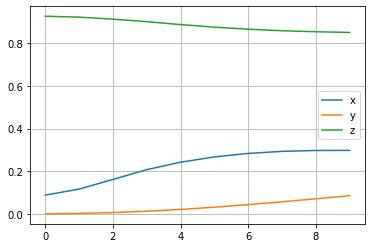

In [12]:
import matplotlib.pyplot as plt
import numpy as np

p = np.squeeze(np.array(traj['p'].T))
plt.plot(p, label=['x', 'y', 'z'])
plt.legend()